# Volume 3: Logistic Regression
    Daniel Perkins
    MATH 403
    11/3/24

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [72]:
class LogiReg(): 
    
    def fit(self, X, y):
        """
        input:
        X: ndarray(n, d)
        y: ndarray(n, 1) taking values only in {0,1}
        
        Save y and X as attributes.
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        n, d = np.shape(X)
        X = np.hstack((np.ones((X.shape[0], 1)), X))  # Add column of ones

        self.X = X
        self.y = y
        
        def loss(beta):  # Define loss function
            left = y * np.log(1+np.exp(-X @ beta))
            right = (1-y) * np.log(1+np.exp(X @ beta))
            loss = np.sum(left + right)
            return loss
        
        initial_beta = np.ones(np.shape(X)[1])  # Pick random beta to start with
        optimal_beta = minimize(loss, initial_beta).x  # Find the value that minimizes it

        self.beta = optimal_beta   # Save the optimal parameters

        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        def sigmoid(x): return 1 / (1+np.exp(-x))  # Sigmoid function
        return sigmoid(x_test @ self.beta)
        
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """      
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))  # Add column of ones
        probs = self.predict_prob(x_test)
        # Make predictions based on the probabilities
        probs[probs>=1/2] = 1
        probs[probs<1/2] = 0
        return probs

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

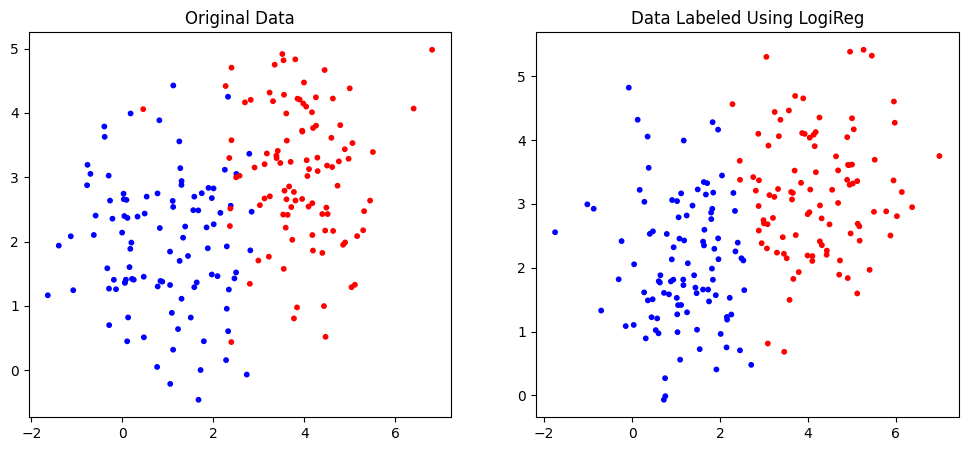

In [95]:
data = np.column_stack((
    np.concatenate((
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1, 2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4, 3]), np.eye(2), 100))), 
    # labels corresonding to each distribution
    np.concatenate((np.zeros(100), np.ones(100)))))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:, :2]
y = data[:, 2].astype(int)

X_test = np.concatenate((
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1, 2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4, 3]), np.eye(2), 100)))
np.random.shuffle(X_test)

# Train the logistic classifier
classifier = LogiReg()
classifier.fit(X, y)
predictions = classifier.predict(X_test)

# Plot the original data and test data
colors1 = np.where(y == 0, 'blue', 'red')  # Use 'blue' for y=0 and 'red' for y=1
colors2 = np.where(predictions == 0, 'blue', 'red')  # Use 'blue' for y=0 and 'red' for y=1
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X[:,0], X[:,1], color=colors1, s=10)
plt.title("Original Data")
plt.subplot(122)
plt.scatter(X_test[:,0], X_test[:,1], color=colors2, s=10)
plt.title("Data Labeled Using LogiReg")
plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels.Logit`, `sklearn.LogisticRegression`, and `sklearn.svm` train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [212]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate((
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100)))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array([1 if pred[i] >= 1/2 else 0 
        for i in range(pred.shape[0])])

# X_test and y_test are generated similar to X and y
X_test = np.concatenate((
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100)))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array([1 if pred[i] >= 1/2 else 0 
        for i in range(pred.shape[0])])



# LogiReg
classifier = LogiReg()
classifier.fit(X, y)
predictions = classifier.predict(X_test)
# Calculate and print out the accuracy
print("LogiReg --> Accuracy:", accuracy_score(predictions, y_test))

# Statsmodels
model = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=0)
predictions = model.predict(sm.add_constant(X_test)).astype(int)
print("Statsmodels --> Accuracy:", accuracy_score(predictions, y_test))

# Sklearn.LogisticRegression
model = LogisticRegression(fit_intercept=True).fit(X,y)
predictions = model.predict(X_test)
print("Sklearn.LogisticRegression --> Accuracy:", accuracy_score(predictions, y_test))

# Sklearn.LogisticRegression
model = svm.SVC(kernel = 'linear').fit(X,y)
predictions = model.predict(X_test)
print("Sklearn.SVM --> Accuracy:", accuracy_score(predictions, y_test))


LogiReg --> Accuracy: 0.955
Statsmodels --> Accuracy: 0.955
Sklearn.LogisticRegression --> Accuracy: 0.985
Sklearn.SVM --> Accuracy: 0.98


On this run, the Sklearn logistic regression worked the best, while my LogiReg function and the Statsmodels one were not quite as good. However, all of the models had over 95% accuracies.

## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels. Also, print the model score

In [217]:
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features.
y = iris.target
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# Train a multinomial logistic regression with added constant feature
model = LogisticRegression(multi_class='multinomial', fit_intercept=True).fit(X, y) 
predictions = model.predict(X_test)

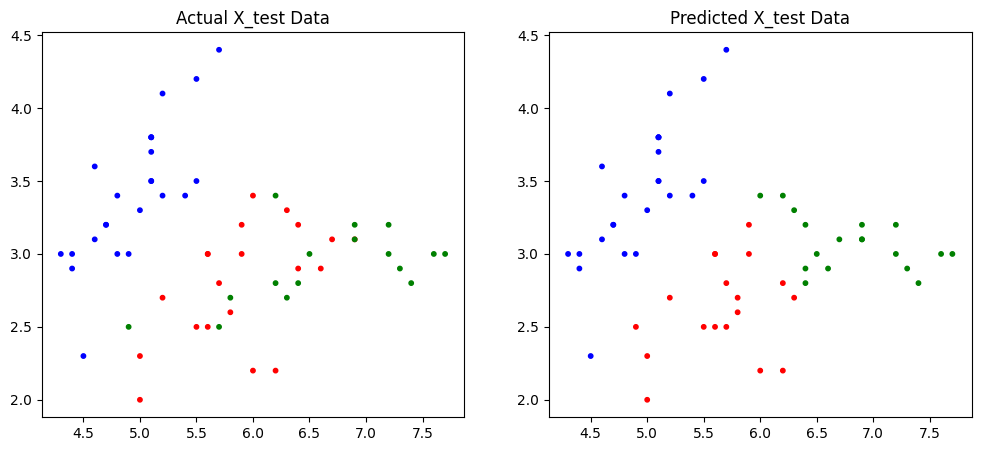

The model's score was 0.8


In [223]:
# Used to color code
conditions1 = [y_test == 0, y_test == 1, y_test == 2]
choices1 = ['blue', 'red', 'green']
colors1 = np.select(conditions1, choices1) 
conditions2 = [predictions == 0, predictions == 1, predictions == 2]
choices2 = ['blue', 'red', 'green']
colors2 = np.select(conditions2, choices2) 

# Plot it
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.scatter(X_test[:,0], X_test[:,1], color=colors1, s=10)
plt.title("Actual X_test Data")
plt.subplot(122)
plt.scatter(X_test[:,0], X_test[:,1], color=colors2, s=10)
plt.title("Predicted X_test Data")
plt.show()

print(f"The model's score was {accuracy_score(predictions, y_test)}")